# Spline transformation in CONCISE

This notebook will demonstrate the use of [spline transformation](http://www.biorxiv.org/content/early/2017/07/18/165183) in CONCISE.

## B-splines crash course

Core component of spline transformation are B-splines (See [Splines, Knots and Penalties](http://statweb.lsu.edu/faculty/marx/SKiP.pdf) by Eilers and and Marx). Here is how they look like and how to compute them with concise.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from concise.utils.splines import BSpline
from concise.preprocessing import EncodeSplines # uses BSpline

Using TensorFlow backend.


In [2]:
def plot_order(degree, ax):
    x = np.linspace(0, 1, 100).reshape((-1,1))
    y = EncodeSplines(n_bases=10, degree=degree).fit_transform(x).squeeze() 
    # alternatively: y = BSpline(0, 1, 10, degree).predict(x)
    ax.plot(x, y)
    ax.set(title="Degree: {d}, order: {o}".format(d=degree, o=degree+1))

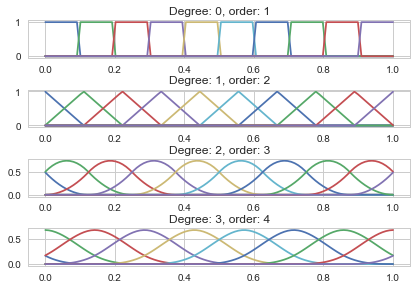

In [3]:
fig, ax = plt.subplots(nrows=4)
fig.tight_layout()
for i in range(ax.shape[0]):
    plot_order(i, ax[i])

We can see that for degree=0, they are just segmenting the range into equally-sized bins.

## Generalized additive models with keras

Let's see how to fit a simple smooth curve, as usually done with generalized additive models (using say [mgcv](https://cran.r-project.org/web/packages/mgcv/) package in R).

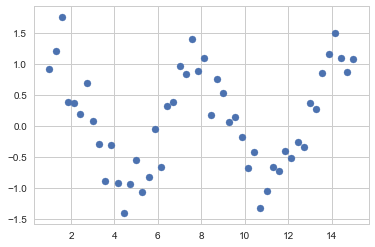

In [13]:
# some data
x = np.linspace(1, 15)
y_true = np.sin(x)
y = y_true + np.random.normal(scale=0.3, size=len(x))

plt.scatter(x,y);

In [14]:
import concise.layers as cl
import concise.regularizers as cr
import keras.layers as kl
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [15]:
# pre-processor
x_spl = EncodeSplines(n_bases=10).fit_transform(x.reshape((-1,1)))

In [16]:
x_spl.shape

(50, 1, 10)

In [19]:
# keras model
m = Sequential([
        cl.SplineT(input_shape=x_spl.shape[1:])
    ])
m.compile(Adam(lr=0.1), "mse")

# TODO - fix this error - check the Keras or TensorFlow version not compatible with it....

ValueError: Shape must be rank 2 but is rank 3 for 'spline_t_5/MatMul' (op: 'MatMul') with input shapes: [1,?,10], [1,10].

In [8]:
m.fit(x_spl, y, epochs=10, verbose=0);

NameError: name 'm' is not defined

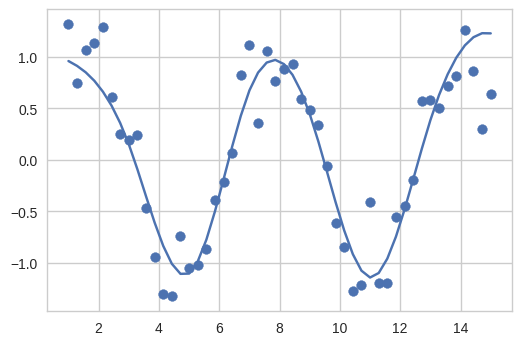

In [490]:
plt.scatter(x,y)
plt.plot(x, m.predict(x_spl));

### Smoothness regularizaion

The advantage of penalized B-splines (P-splines) is that we can use a large number of spline knots with smoothness regularization. In concise, this is achieved by adding a regularizer to the `SplineT` layer: `concise.regularizers.SplineSmoother(diff_order=2, l2_smooth=0.0, l2=0.0)`.

In [1]:
def fit_lines(x, n_bases=10, l2_smooth=0, diff_order=2):
    # train the pre-processor
    es = EncodeSplines(n_bases=n_bases)
    es.fit(x.reshape((-1,1)))
    
    # train the model
    x_spl = es.transform(x.reshape((-1,1)))
    m = Sequential([
            cl.SplineT(kernel_regularizer=cr.SplineSmoother(diff_order=diff_order, # Smoothness regularization
                                                            l2_smooth=l2_smooth),
                       input_shape=x_spl.shape[1:])
                    ])
    m.compile(Adam(lr=0.1), "mse")
    m.fit(x_spl, y, epochs=150, verbose=0)
    
    # denser grid to predict
    x_pred = np.linspace(x.min(), x.max(), num=100)
    return x_pred, m.predict(es.transform(x_pred.reshape((-1,1))))

In [493]:
# Generate data
x = np.linspace(1, 15, num=20)
y_true = np.sin(x)
y = y_true + np.random.normal(scale=0.3, size=len(x))

In [494]:
l2s_list = [0, 10]
y_pred_l = [fit_lines(x, n_bases=50, l2_smooth=l2s) for l2s in l2s_list]

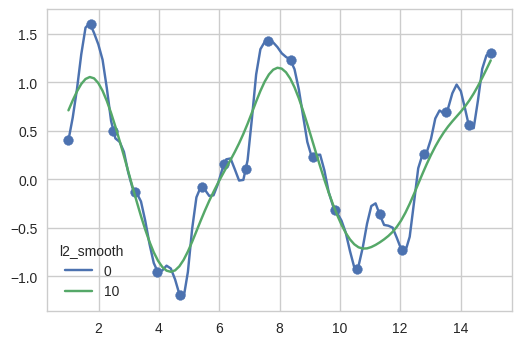

In [495]:
plt.scatter(x,y)
for i, (x_pred, y_pred) in enumerate(y_pred_l):
    plt.plot(x_pred, y_pred, label=l2s_list[i])
plt.legend(title="l2_smooth");    

## SplineT in sequence-based models

Let's show a simple use-case of spline transformation in the context of DNA sequence-based models. The core idea is to have, in addition to sequence, a scalar vector along the sequence encoding distances to some genomic landmarks. For simplicity, we will here consider the distance within the sequence. 

We will use a simple simulated dataset, where multiple TTAATGA motifs were embeded in the sequence and the response was computed as the sum of the position-dependent motif effects:

$$ f_{pos} (x) = 0.3*\frac{1}{\sqrt{2 \pi 0.01}} \exp{\{- \frac{(x - 0.2)^2}{0.02}\}} + 0.05 \sin(15 x) + 0.8 \;,$$

where $x\in[0,1]$ is the position within the sequence.

In [496]:
from scipy.stats import norm
pef = lambda x: 0.3*norm.pdf(x, 0.2, 0.1) + 0.05*np.sin(15*x) + 0.8

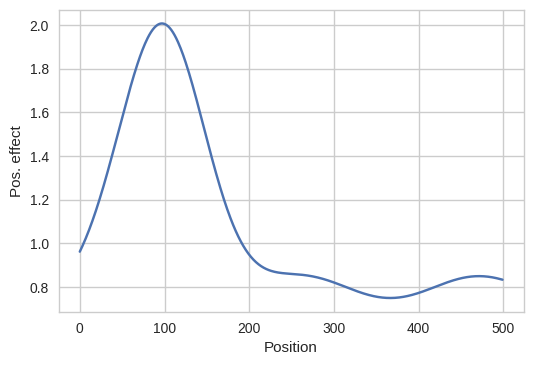

In [497]:
pos_effect_theoretical = pef(np.arange(seq_length)/seq_length)
plt.plot(pos_effect_theoretical);
plt.xlabel("Position")
plt.ylabel("Pos. effect");

In [498]:
from concise.preprocessing import encodeDNA
from concise.utils.pwm import PWM
import concise.initializers as ci
from keras.callbacks import EarlyStopping

In [499]:
# Load the data
data_dir = "../data/"
dt = pd.read_csv(data_dir + "/01-fixed_seq_len-1.csv")
motifs = ["TTAATGA"]
dt

,y,seq
0,5.4763,TTCTGGGAGGCGTCCTTACGT...
1,0.2309,AAGTATGATCATACGCACCGT...
2,6.0881,TATGCAGGATCGAAATACTCT...
...,...,...
2997,0.2773,GAGGGGTCAGCATGCGTATGA...
2998,15.6793,CTACCAAATCCAAACTTCAGC...
2999,13.0256,CTGACCATACGTTTCACACCG...


In [500]:
# Create arrays for model training
x_seq = encodeDNA(dt["seq"])
y = dt.y.as_matrix()
seq_length = x_seq.shape[1]

x_seq.shape # (n_samples, seq_length, n_bases)

(3000, 500, 4)

In [501]:
# positional track
x_pos = np.repeat(np.arange(seq_length).reshape((1,-1)), y.shape[0], axis=0)
x_pos[:5]

array([[  0,   1,   2, ..., 497, 498, 499],
       [  0,   1,   2, ..., 497, 498, 499],
       [  0,   1,   2, ..., 497, 498, 499],
       [  0,   1,   2, ..., 497, 498, 499],
       [  0,   1,   2, ..., 497, 498, 499]])

In [502]:
# default data-format for SplineT positions is: (N_batch, seq_length, channels)
x_pos = x_pos.reshape((-1, seq_length, 1)) 
x_pos.shape

(3000, 500, 1)

In [2]:
# transform positions with the EncodeSplines pre-processor
es = EncodeSplines(n_bases=10)
x_pos_spl = es.fit_transform(x_pos)
# This adds a new axis n_bases to the end
x_pos_spl.shape

NameError: name 'EncodeSplines' is not defined

In [504]:
# Compile the training set
train = {"seq": x_seq, "pos": x_pos_spl}, y

[PWM(name: None, consensus: TTAATGA)]


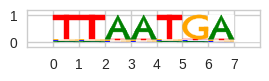

In [505]:
# To make the task easier, we will initialize the filters 
# of the conv layer to the simulated motif
pwm_list = [PWM.from_consensus(motif) for motif in motifs]
motif_width = 7
print(pwm_list)
pwm_list[0].plotPWM(figsize=(3,0.5));

In [506]:
def model_SplineT(n_bases=10):
    """Create Keras model based on two data inputs: sequence and scalar-vector along the sequence"""
    np.random.seed(42)

    # DNA input
    input_dna = cl.InputDNA(seq_length, name="seq")
    
    # Positions input
    input_pos = kl.Input((seq_length, 1, n_bases), name="pos")

    # Sequence module
    x_seq = cl.ConvDNA(filters=1, 
                       kernel_size=motif_width, ## motif width
                       activation="relu", 
                       # motif initialization
                       kernel_initializer=ci.PSSMKernelInitializer(pwm_list),
                       bias_initializer=ci.PSSMBiasInitializer(pwm_list,
                                                               kernel_size=motif_width, 
                                                               mean_max_scale=0.99),
                       padding="same",
                       name="conv_dna",
                       ## mean_max_scale of 1 means that only consensus sequence gets score larger than 0
                      )(input_dna)
    
    # Positional module
    x_pos = cl.SplineT(kernel_regularizer=cr.SplineSmoother(l2_smooth=1e-3), 
                       kernel_initializer="zeros",
                       name="SplineT")(input_pos)
    x_pos = kl.Lambda(lambda x: 1 + x)(x_pos)
    
    # Merge
    x = kl.multiply([x_seq, x_pos])
    x = cl.GlobalSumPooling1D()(x)
    x = kl.Dense(units=1,activation="linear")(x)
    model = Model(inputs=[input_dna, input_pos], outputs=x)

    # compile the model
    model.compile(optimizer=Adam(lr=0.1), loss="mse")
    return model

In [507]:
# Get the compiled model
m = model_SplineT()

In [508]:
# Train
np.random.seed(42)
m.fit(train[0], train[1],
      epochs=30, verbose=2,
      callbacks=[EarlyStopping(patience=5)],
      validation_split=.2);

Train on 2400 samples, validate on 600 samples
Epoch 1/30
1s - loss: 2.5419 - val_loss: 1.8295
Epoch 2/30
0s - loss: 1.7054 - val_loss: 1.5672
Epoch 3/30
0s - loss: 1.6369 - val_loss: 1.5443
Epoch 4/30
0s - loss: 1.7399 - val_loss: 1.6347
Epoch 5/30
0s - loss: 1.7901 - val_loss: 1.6153
Epoch 6/30
0s - loss: 1.8274 - val_loss: 1.5483
Epoch 7/30
0s - loss: 1.6986 - val_loss: 1.9023
Epoch 8/30
0s - loss: 1.6648 - val_loss: 1.6608
Epoch 9/30
0s - loss: 1.7629 - val_loss: 1.5500


In [509]:
## visualize the effect
w_pos = m.get_layer("SplineT").get_weights()[0]
x_pos_single = train[0]["pos"][0,:,0,:]

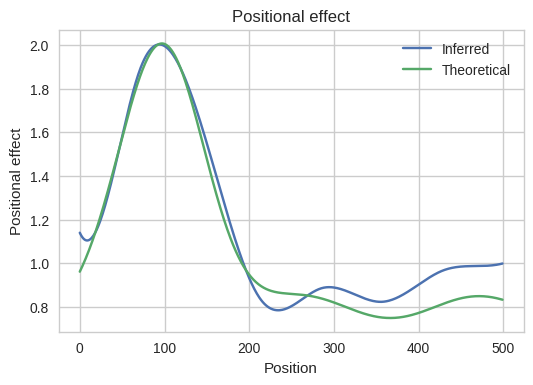

In [510]:
plt.plot(1 + np.dot(x_pos_single, np.ravel(w_pos)))
plt.plot(pos_effect_theoretical);
plt.ylabel('Positional effect')
plt.xlabel('Position')
plt.title("Positional effect")
plt.legend(labels=["Inferred", "Theoretical"]);

### Convenience function: SplineWeight1D

Concise provides a shortcut to modelling internal positions: `SplineWeight1D`.

In [511]:
def model_SplineWeight1D():
    np.random.seed(42)
    model = Sequential([
                cl.ConvDNA(filters=1, 
                       kernel_size=motif_width, ## motif width
                       activation="relu", 
                       kernel_initializer=ci.PSSMKernelInitializer(pwm_list),
                       bias_initializer=ci.PSSMBiasInitializer(pwm_list,kernel_size=motif_width, mean_max_scale=0.99),
                       padding="same",
                       name="conv_dna",
                       seq_length=seq_length
                       ## mean_max_scale of 1 means that only consensus sequence gets score larger than 0
                      ),
                cl.SplineWeight1D(n_bases=10, l2_smooth=1e-3, l2=0, name="spline_weight"),
                cl.GlobalSumPooling1D(),
                kl.Dense(units=1,activation="linear")
        ])
    model.compile(optimizer=Adam(lr=0.1), loss="mse")
    return model

In [512]:
# Train
np.random.seed(42)
m = model_SplineWeight1D()
m.fit(train[0]["seq"], train[1],
      epochs=30, verbose=2,
      callbacks=[EarlyStopping(patience=5)],
      validation_split=.2);

Train on 2400 samples, validate on 600 samples
Epoch 1/30
1s - loss: 2.4538 - val_loss: 1.8191
Epoch 2/30
0s - loss: 1.6336 - val_loss: 1.5477
Epoch 3/30
0s - loss: 1.6393 - val_loss: 1.6724
Epoch 4/30
0s - loss: 1.6772 - val_loss: 1.4956
Epoch 5/30
0s - loss: 1.7510 - val_loss: 1.6853
Epoch 6/30
0s - loss: 1.9881 - val_loss: 1.8725
Epoch 7/30
0s - loss: 1.8552 - val_loss: 1.6671
Epoch 8/30
0s - loss: 1.8011 - val_loss: 1.5408
Epoch 9/30
0s - loss: 1.6724 - val_loss: 1.7244
Epoch 10/30
0s - loss: 1.6850 - val_loss: 1.7324


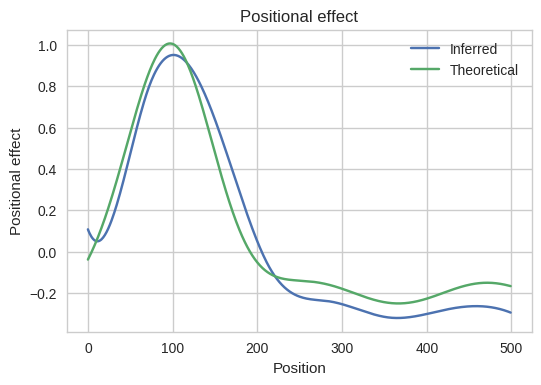

In [513]:
# plot
m.get_layer("spline_weight").plot() # layer also has a plotting method
plt.plot(positions, pos_effect_theoretical - 1)
plt.ylabel('Positional effect')
plt.xlabel('Position')
plt.title("Positional effect")
plt.legend(labels=["Inferred", "Theoretical"]);